In [2]:
import pandas as pd
import glob
import tensorflow as tf
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import efficientnet.tfkeras as efn
import os

In [6]:
#create a dataframe with column "path and 0 for fake and 1 for real"
df = pd.DataFrame(0,columns = ['paths','Deepfake'], index = range(10903))
cnt = 0
filepaths = glob.glob("./data/Dataset/Test/Fake/*")
print("Validation Deepfake count : " , len(filepaths))
for filepath in filepaths:
  df.iloc[cnt,0] = filepath
  df.iloc[cnt,1] = 0
  cnt+=1
filepaths = glob.glob("./data/Dataset/Test/Real/*")
print("Validation Real count : " , len(filepaths))
for filepath in filepaths:
  df.iloc[cnt,0] = filepath
  df.iloc[cnt,1] = 1
  cnt+=1
print("Total count : ", cnt)
print("value count :")
print(df['Deepfake'].value_counts())

Validation Deepfake count :  5490


C:\Users\juiklee\AppData\Local\Temp\ipykernel_5208\389304336.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value './data/Dataset/Test/Fake\fake_10.jpg' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[cnt,0] = filepath


Validation Real count :  5413
Total count :  10903
value count :
Deepfake
0    5490
1    5413
Name: count, dtype: int64


In [7]:
print(df)

                                        paths  Deepfake
0        ./data/Dataset/Test/Fake\fake_10.jpg         0
1       ./data/Dataset/Test/Fake\fake_100.jpg         0
2      ./data/Dataset/Test/Fake\fake_1000.jpg         0
3      ./data/Dataset/Test/Fake\fake_1001.jpg         0
4      ./data/Dataset/Test/Fake\fake_1002.jpg         0
...                                       ...       ...
10898   ./data/Dataset/Test/Real\real_995.jpg         1
10899   ./data/Dataset/Test/Real\real_996.jpg         1
10900   ./data/Dataset/Test/Real\real_997.jpg         1
10901   ./data/Dataset/Test/Real\real_998.jpg         1
10902   ./data/Dataset/Test/Real\real_999.jpg         1

[10903 rows x 2 columns]


In [8]:
from sklearn.model_selection import train_test_split
SEED = 42
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['Deepfake'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['Deepfake'])

In [9]:
print(train_df)

                                       paths  Deepfake
9116  ./data/Dataset/Test/Real\real_4261.jpg         1
5428   ./data/Dataset/Test/Fake\fake_943.jpg         0
8789  ./data/Dataset/Test/Real\real_3968.jpg         1
5598  ./data/Dataset/Test/Real\real_1095.jpg         1
6344  ./data/Dataset/Test/Real\real_1767.jpg         1
...                                      ...       ...
1797  ./data/Dataset/Test/Fake\fake_2617.jpg         0
3586  ./data/Dataset/Test/Fake\fake_4227.jpg         0
2244  ./data/Dataset/Test/Fake\fake_3019.jpg         0
5305   ./data/Dataset/Test/Fake\fake_832.jpg         0
1547  ./data/Dataset/Test/Fake\fake_2392.jpg         0

[7413 rows x 2 columns]


In [10]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)

    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['Deepfake'])
    return imgs, df #imgs = numpy array & #
train_imgs, train_df = create_datasets(train_df,IMG_WIDTH,IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df,IMG_WIDTH,IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df,IMG_WIDTH,IMG_HEIGHT)

100%|█████████████████████████████████████████████████████████████████████████████| 2181/2181 [00:12<00:00, 180.50it/s]


In [11]:
train_imgs/=255.0
val_imgs/=255.0
test_imgs/255.0

array([[[[0.7490196 , 0.6392157 , 0.5921569 ],
         [0.7411765 , 0.6313726 , 0.58431375],
         [0.73333335, 0.62352943, 0.5803922 ],
         ...,
         [0.7882353 , 0.75686276, 0.7137255 ],
         [0.78431374, 0.7529412 , 0.7019608 ],
         [0.78039217, 0.7490196 , 0.69803923]],

        [[0.74509805, 0.63529414, 0.5882353 ],
         [0.7372549 , 0.627451  , 0.5803922 ],
         [0.7294118 , 0.61960787, 0.5764706 ],
         ...,
         [0.7921569 , 0.7607843 , 0.7176471 ],
         [0.7882353 , 0.75686276, 0.7058824 ],
         [0.78431374, 0.7529412 , 0.7019608 ]],

        [[0.7411765 , 0.6313726 , 0.58431375],
         [0.73333335, 0.62352943, 0.5764706 ],
         [0.7254902 , 0.6156863 , 0.57254905],
         ...,
         [0.8       , 0.76862746, 0.7254902 ],
         [0.79607844, 0.7647059 , 0.7137255 ],
         [0.79607844, 0.7647059 , 0.7137255 ]],

        ...,

        [[0.5372549 , 0.627451  , 0.8392157 ],
         [0.5294118 , 0.61960787, 0.83137256]

In [12]:
print(train_df.head())

          0      1
9116  False   True
5428   True  False
8789  False   True
5598  False   True
6344  False   True


In [13]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB7(
        input_shape=(img_height,img_width,n),
        weights='imagenet',
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy']) 
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnet-b7 (Functiona  (None, 8, 8, 2560)        64097680  
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 2560)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 5122      
                                                                 
Total params: 64102802 (244.53 MB)
Trainable params: 63792082 (243.35 MB)
Non-trainable params: 310720 (1.19 MB)
_________________________________________________________________


In [14]:
generator = ImageDataGenerator(horizontal_flip=True,
                               height_shift_range=0.1,
                               fill_mode='reflect')

es_callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                               verbose=1,
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

In [15]:
BATCH_SIZE = 64
history = model.fit(generator.flow(train_imgs,
                                   train_df,
                                   batch_size=BATCH_SIZE),
                    epochs=1,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

115/115 [==============================] - 20879s 180s/step - loss: 0.6823 - accuracy: 0.5601 - val_loss: 0.6685 - val_accuracy: 0.5837 - lr: 3.0000e-06


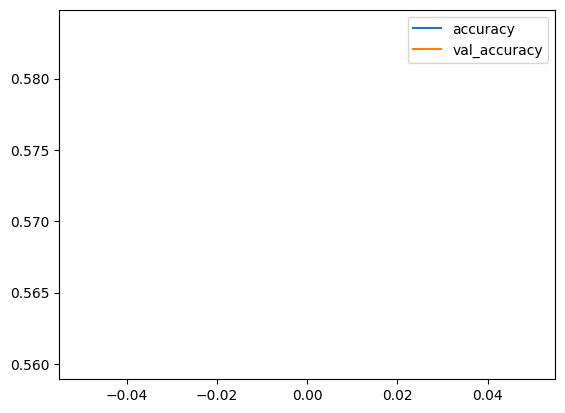

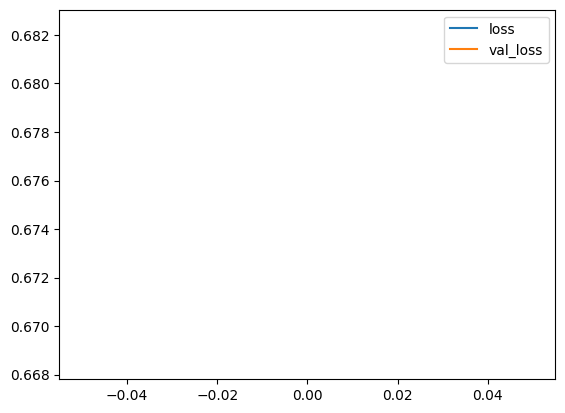

In [16]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

C:\Users\juiklee\anaconda3\envs\project\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


모델이 저장되었습니다.


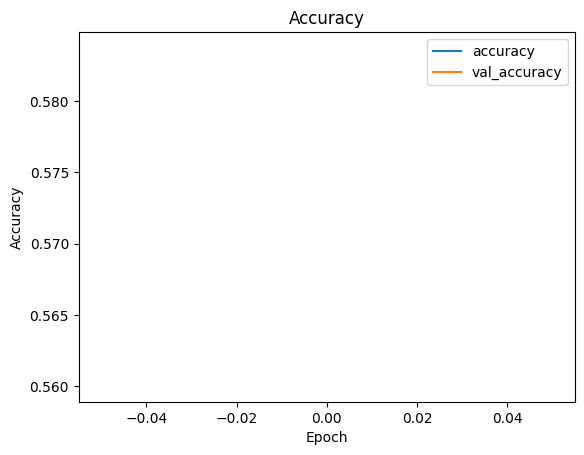

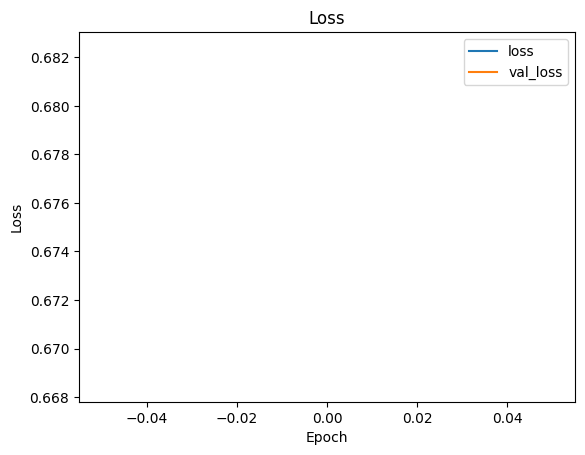

In [17]:
model.save('trained_model.h5')
print("모델이 저장되었습니다.")

# 훈련 결과 시각화
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

69/69 [==============================] - 400s 6s/step


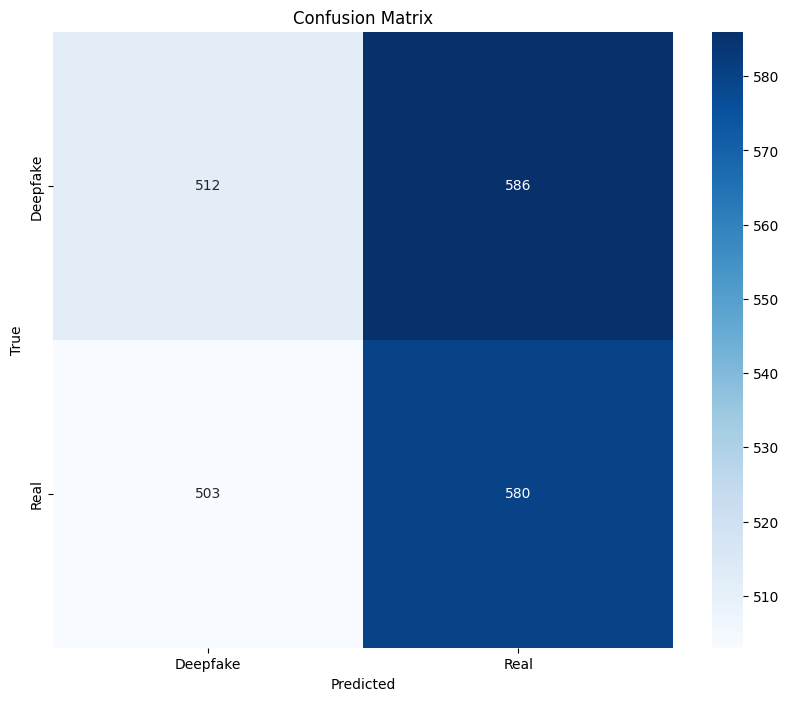

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


label_names = ["Deepfake","Real"]

predictions = model.predict(test_imgs)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

true_labels = np.argmax(test_df.values, axis=1)  # Convert one-hot encoded labels to class labels

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()